# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.custom_formatter import setup_logger
logger = setup_logger(__name__)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Import file
df_import = pd.read_csv("../data/crsp_voo.csv")

df = df_import.copy()

# rename columns 
df.columns = [col.lower().replace("dly", "") for col in df.columns]

# Filter only for the ETF, a different security existed before with the same ticker
df = df[df["permco"]==41593]


In [4]:


def adjust_for_splits(df:pd.DataFrame, col="prc"):
    """ 
    Refactor price for splits etc, keeping the first one as a base value    
    If the company has a 2:1 split and the price moves from 100 to 50
    Our timeseries will show t_0=50, t_1=50
    """
    # copy df
    df = df.copy()

    # filter
    df = df[[col, "facprc"]]

    # Substitute factor columns (shows different  value only when the split occurs) 
    df["facprc"] = np.where(df["facprc"]==1, np.nan, df["facprc"]) 
    # impose the last one as 1
    df.loc[-1,"facprc"] = 1
    df["facprc"] = df["facprc"].bfill()
    
    # Recompute columns
    df[col] = df[col] / df["facprc"].shift(-1)

    return df[col]



In [5]:

#TODO: how should we treat dividends? read literature
# Include dividends if we care about returns
# We define prices with dividends 
#df["prcdiv"] = df["prc"] - df["orddivamt"]

# Refactor value columns
value_cols = ["prc", "close", "low", "high", "bid", "ask", "open"]
for col in value_cols:
    df[col] = adjust_for_splits(df, col)




# Define columns of interest
cols_to_keep = ["permco", "yyyymmdd", "ret", "prc", "cap", "orddivamt","vol", "close", "low", "high", "bid", "ask", "open", "shrout", "sprtrn", "facprc"]
df = df[cols_to_keep].dropna()
# convert date column to datetime object
df["yyyymmdd"] = pd.to_datetime(df["yyyymmdd"], format="%Y%m%d") 

df

,permco,yyyymmdd,ret,prc,cap,orddivamt,vol,close,low,high,bid,ask,open,shrout,sprtrn,facprc
1,41593,2010-09-10,0.004540,101.780,2.636102e+04,0.0,17300,101.780,101.2960,101.8600,101.86,101.90,101.68,518,0.004863,1.0
2,41593,2010-09-13,0.012576,103.060,2.669254e+04,0.0,67500,103.060,102.5000,103.1400,103.00,103.04,102.96,518,0.011131,1.0
3,41593,2010-09-14,-0.000213,103.038,2.668684e+04,0.0,118800,103.038,102.3800,103.4800,102.88,102.92,102.84,518,-0.000713,1.0
4,41593,2010-09-15,0.002543,103.300,2.675470e+04,0.0,18600,103.300,102.4000,103.3800,103.30,103.34,102.62,518,0.003541,1.0
5,41593,2010-09-16,-0.000387,103.260,2.674434e+04,0.0,119200,103.260,102.7000,103.3200,103.30,103.32,103.02,518,-0.000364,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,41593,2024-12-24,0.010289,552.820,5.883879e+08,0.0,3439250,552.820,547.5400,552.9000,552.79,552.84,548.06,1064339,0.011043,1.0
3598,41593,2024-12-26,-0.000018,552.810,5.883772e+08,0.0,4496268,552.810,549.9201,553.9700,552.81,552.84,551.20,1064339,-0.000406,1.0
3599,41593,2024-12-27,-0.010365,547.080,5.822786e+08,0.0,7077135,547.080,543.2001,549.6200,547.08,547.09,549.37,1064339,-0.011056,1.0
3600,41593,2024-12-30,-0.011132,540.990,5.757968e+08,0.0,6505089,540.990,537.4000,544.0900,540.88,540.89,540.56,1064339,-0.010702,1.0


# EOD

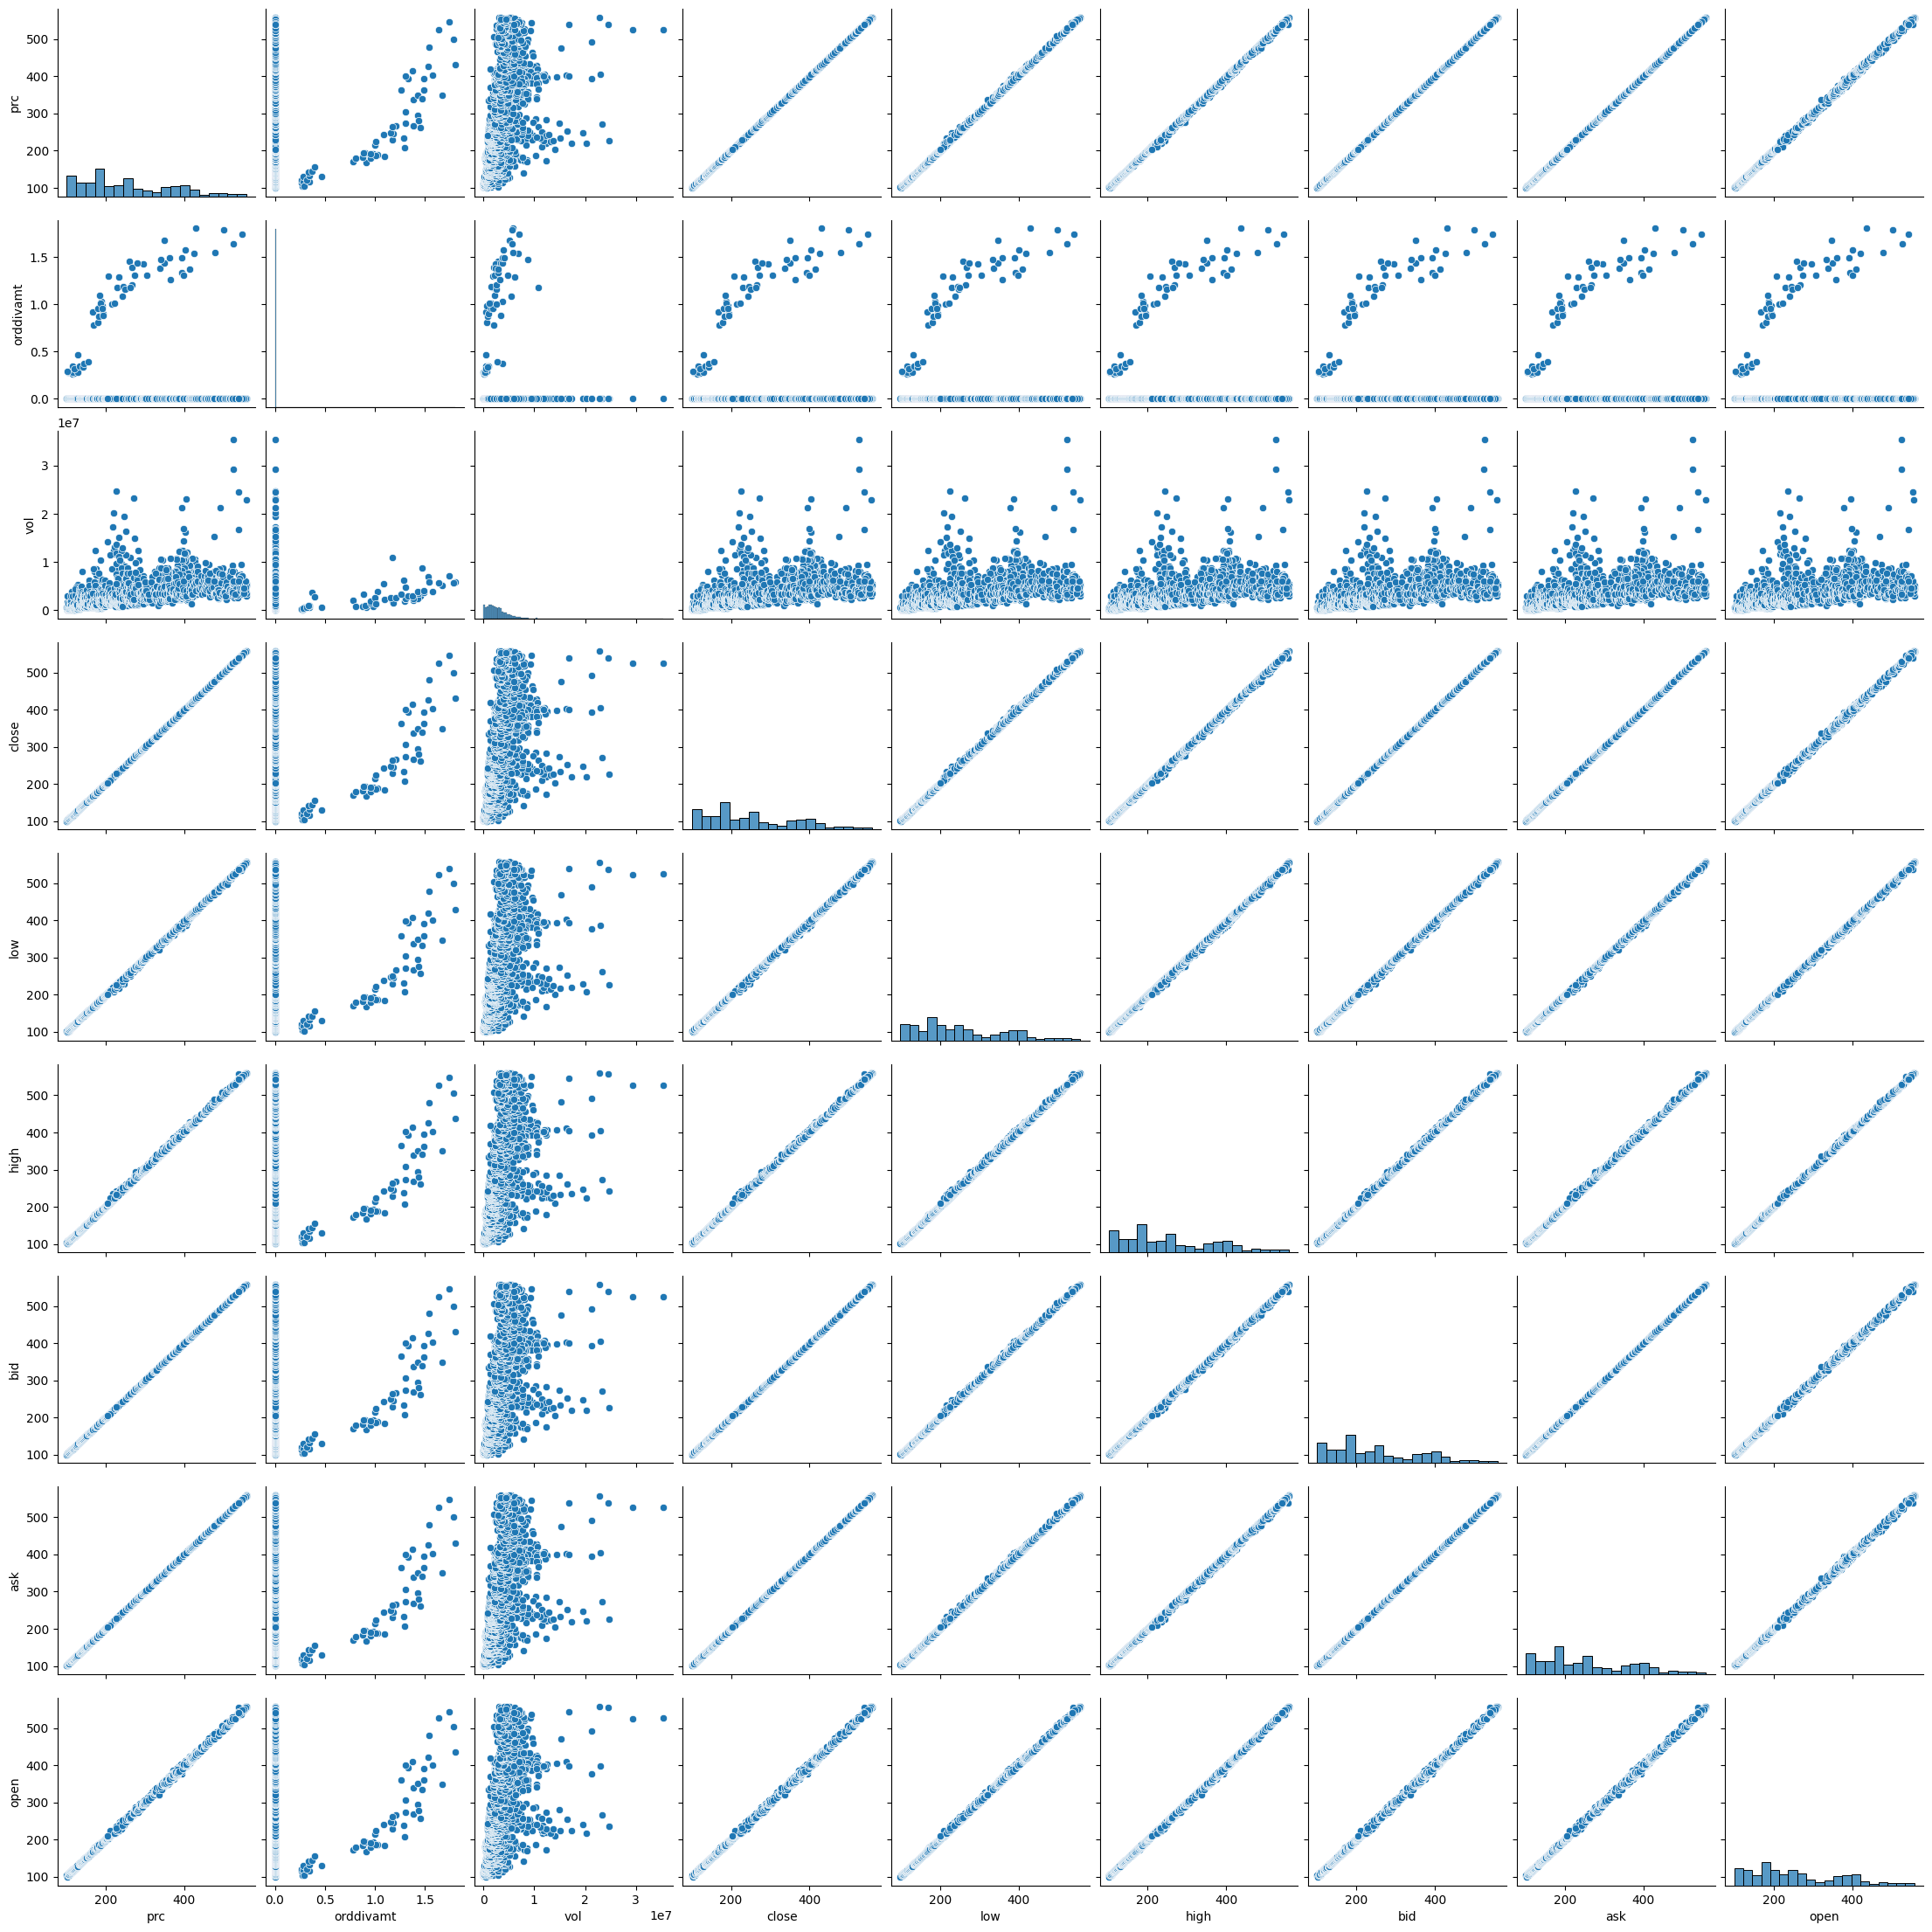

In [6]:

sns.pairplot(df[["prc", "orddivamt","vol", "close", "low", "high", "bid", "ask", "open"]])

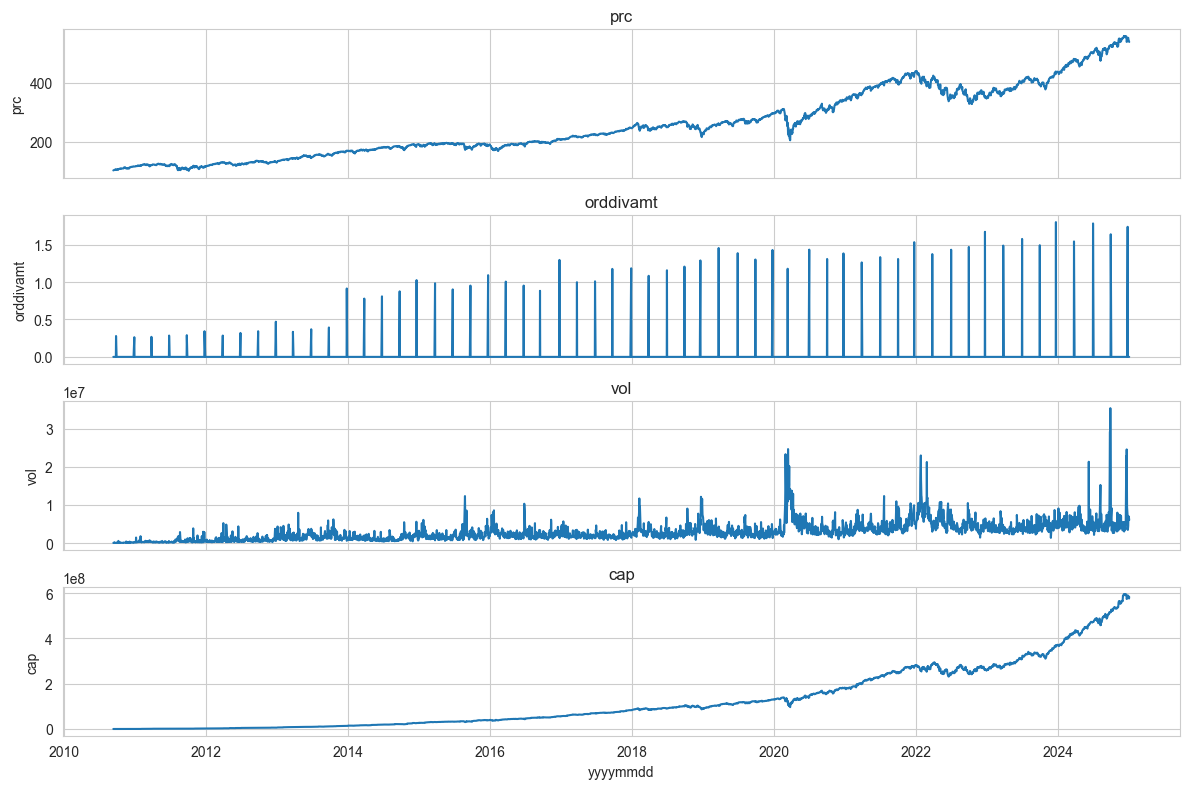

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

cols = ["prc", "orddivamt","vol", "cap"]

fig, axes = plt.subplots(len(cols), 1, figsize=(12, 2*len(cols)), sharex=True)

for ax, col in zip(axes, cols):
    sns.lineplot(x="yyyymmdd", y=col, data=df, ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()


d:\Research\FinNN\finNN_code\venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


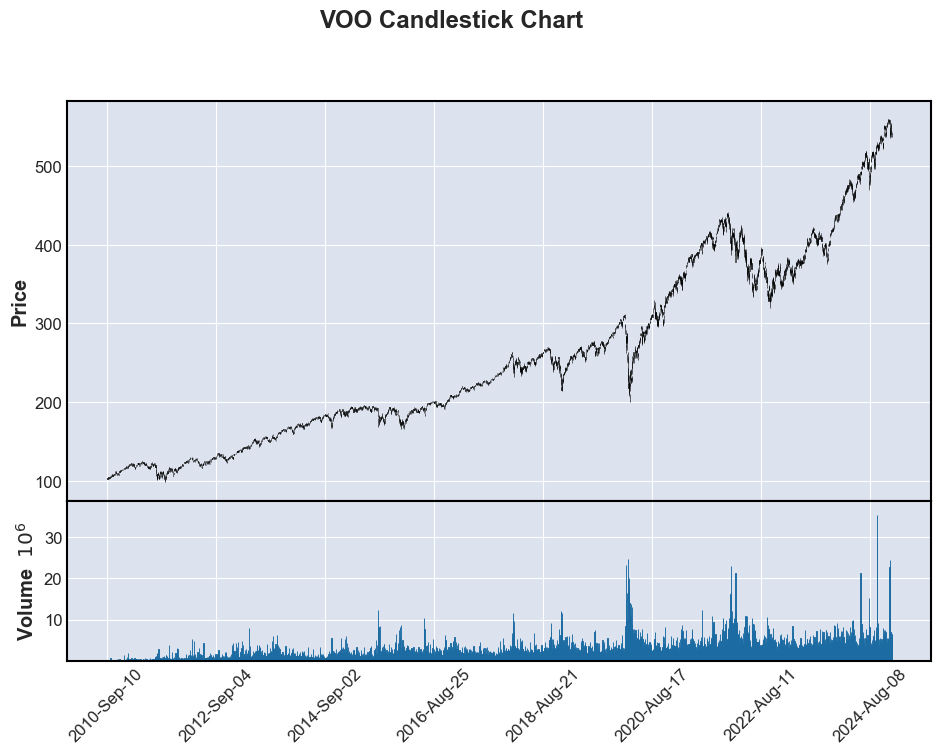

In [8]:
import mplfinance as mpf

df_candle = df.copy()
df_candle["date"] = pd.to_datetime(df_candle["yyyymmdd"], format="%Y%m%d")
df_candle = df_candle.rename(columns={"vol":"volume"})
df_candle = df_candle.set_index("date")

mpf.plot(
    df_candle,
    type="candle",
    volume=True,
    title="VOO Candlestick Chart",
    figsize=(12,8)
)


# Baselines

Here we try some common baselines models to then assess the performance of the proposed models

Model Below: https://onlinelibrary.wiley.com/doi/10.1155/2020/6622927

In [10]:
# Import TensorFlow and Keras for building the CNN-LSTM model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU Available: []


In [11]:
# Data preparation for CNN-LSTM model
def create_sequences(data, sequence_length=10, target_col='prc'):
    """
    Create sequences of data suitable for time series prediction
    
    Args:
        data: DataFrame with time series data
        sequence_length: Number of time steps to look back (window size)
        target_col: Column to predict
    
    Returns:
        X: Input sequences (samples, timesteps, features)
        y: Target values
    """
    # Sort by date to ensure proper sequence order
    data = data.sort_values('yyyymmdd').reset_index(drop=True)
    
    # Select features for input (excluding target and date columns)
    feature_cols = ['ret', 'vol', 'close', 'low', 'high', 'bid', 'ask', 'open']
    features = data[feature_cols].values
    target = data[target_col].values
    
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        # Get sequence of features
        X.append(features[i-sequence_length:i])
        # Get target value
        y.append(target[i])
    
    return np.array(X), np.array(y)

# Prepare the data
print("Preparing data for CNN-LSTM model...")
print(f"Original data shape: {df.shape}")

# Create sequences with a window of 10 time steps (matching the diagram input)
sequence_length = 10
X, y = create_sequences(df, sequence_length=sequence_length, target_col='prc')

print(f"Sequence data shape: X={X.shape}, y={y.shape}")
print(f"Input shape per sample: {X.shape[1:]} (timesteps, features)")

# Split the data into train and test sets (80-20 split)
# Use temporal split to avoid data leakage
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit and transform
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("Data scaling completed.")
print(f"Scaled training set: X_train={X_train_scaled.shape}, y_train={y_train_scaled.shape}")
print(f"Feature range after scaling: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"Target range after scaling: [{y_train_scaled.min():.3f}, {y_train_scaled.max():.3f}]")

Preparing data for CNN-LSTM model...
Original data shape: (3601, 16)
Sequence data shape: X=(3591, 10, 8), y=(3591,)
Input shape per sample: (10, 8) (timesteps, features)
Training set: X_train=(2872, 10, 8), y_train=(2872,)
Test set: X_test=(719, 10, 8), y_test=(719,)
Data scaling completed.
Scaled training set: X_train=(2872, 10, 8), y_train=(2872,)
Feature range after scaling: [0.000, 1.000]
Target range after scaling: [0.000, 1.000]


In [13]:
# Build CNN-LSTM model architecture
def build_cnn_lstm_model(input_shape):
    """
    Build the CNN-LSTM model as shown in the architecture diagram
    
    Architecture:
    - Input layer: (None, 10, 8) - 10 timesteps, 8 features
    - Conv1D layer: 32 filters
    - MaxPooling1D layer 
    - LSTM layer: 64 units
    - Dense layer: 1 output
    
    Args:
        input_shape: Shape of input data (timesteps, features)
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # Input layer - matches the diagram (None, 10, 8)
        layers.InputLayer(input_shape=input_shape),
        
        # Conv1D layer - extract local patterns from time series
        # 32 filters as shown in diagram output (None, 10, 32)
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        
        # MaxPooling1D layer - downsample and reduce dimensionality
        # Keeps the shape as (None, 10, 32) based on diagram
        layers.MaxPooling1D(pool_size=1),  # pool_size=1 to maintain sequence length
        
        # LSTM layer - capture temporal dependencies
        # 64 units as shown in diagram output (None, 64)
        layers.LSTM(64, return_sequences=False),
        
        # Dropout for regularization
        layers.Dropout(0.2),
        
        # Dense output layer - single value prediction
        # 1 unit as shown in diagram output (None, 1)
        layers.Dense(1, activation='linear')
    ])
    
    return model

# Create the model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])  # (timesteps, features)
print(f"Input shape for model: {input_shape}")

model = build_cnn_lstm_model(input_shape)

# Display model architecture
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='cnn_lstm_model.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB'
)

Input shape for model: (10, 8)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,697 (100.38 KB)

 Trainable params: 25,697 (100.38 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# Compile and train the model
# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for regression
    metrics=['mse']  # Mean Absolute Error
)

print("Model compiled successfully!")

# Set up callbacks for training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001
)

# Train the model
print("Starting model training...")
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Model training completed!")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.show()

Model compiled successfully!
Starting model training...
Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.0847e-04 - mse: 9.0847e-04 - val_loss: 7.6671e-04 - val_mse: 7.6671e-04 - learning_rate: 0.0010
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7115e-04 - mse: 6.7115e-04 - val_loss: 0.0013 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.0862e-04 - mse: 7.0862e-04 - val_loss: 5.4343e-04 - val_mse: 5.4343e-04 - learning_rate: 0.0010
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4862e-04 - mse: 7.4862e-04 - val_loss: 0.0010 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5884e-04 - mse: 7.5884e-04 - val_loss: 5.0896e-04 - val_mse: 5.0896e-04 - learning_rate: 0.0010
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7697e-04 - mse: 6.7697e-04 - val_loss: 4.4746e-04 - val_mse: 4.4746e-04 - learning_rate: 0.0010
Epoch 7/100
90/90 

Making predictions...
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

=== CNN-LSTM Model Performance ===
Training Set:
  MSE: 10.2624
  MAE: 2.0249
  R²:  0.9985

Test Set:
  MSE: 52.1596
  MAE: 5.5631
  R²:  0.9864

=== Baseline Performance (Previous Day Price) ===
  MSE: 18.9844
  MAE: 3.2620
  R²:  0.9951


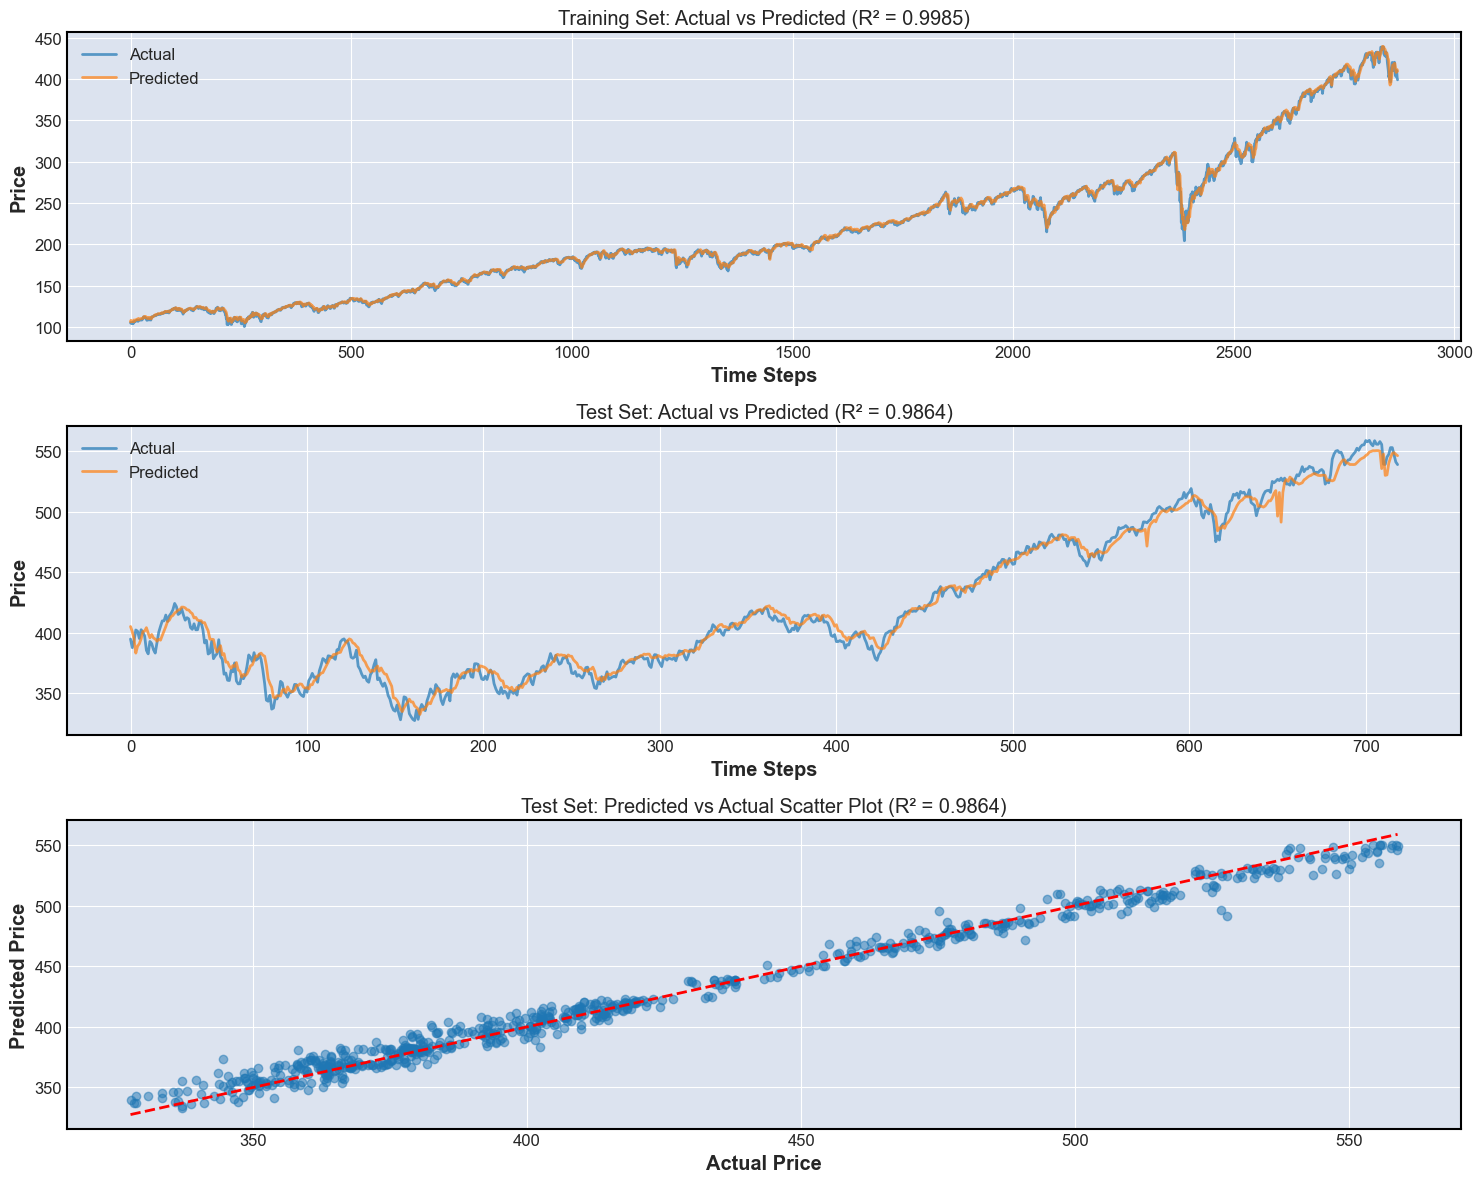

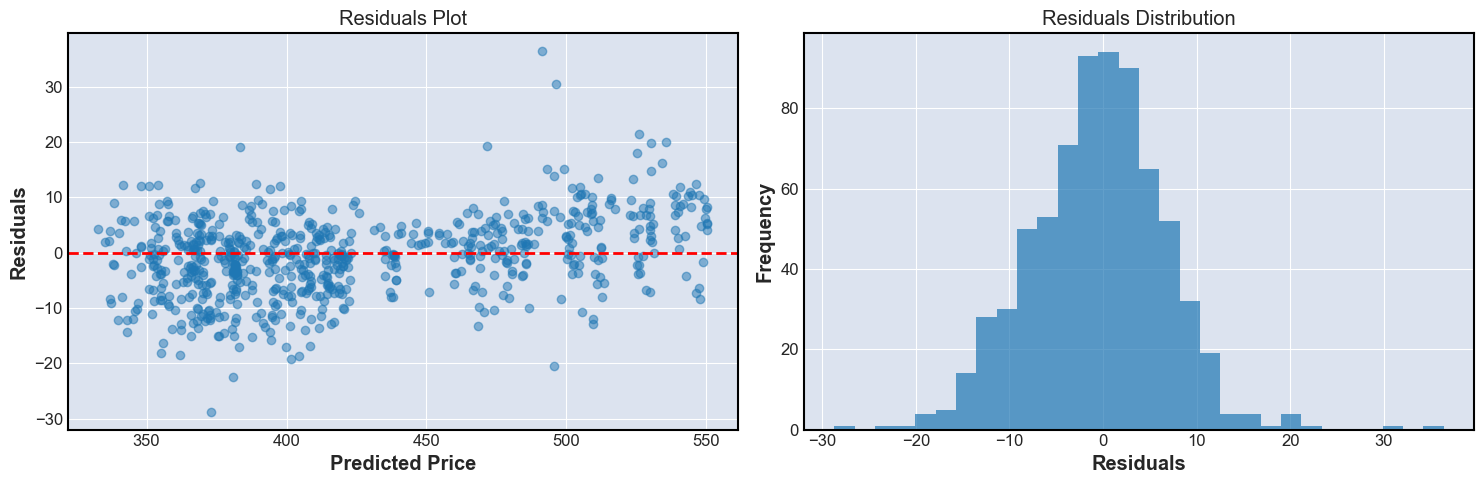


Model improvement over baseline:
MSE improvement: -174.75%
MAE improvement: -70.54%


In [15]:
# Model evaluation and predictions
# Make predictions
print("Making predictions...")
y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

# Inverse transform to get actual price values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# Flatten arrays
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()
y_train_actual = y_train_actual.flatten()
y_test_actual = y_test_actual.flatten()

# Calculate metrics
train_mse = mean_squared_error(y_train_actual, y_train_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print("\n=== CNN-LSTM Model Performance ===")
print(f"Training Set:")
print(f"  MSE: {train_mse:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²:  {train_r2:.4f}")
print(f"\nTest Set:")
print(f"  MSE: {test_mse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²:  {test_r2:.4f}")

# Calculate baseline (naive prediction - previous day's price)
# For baseline, predict the last known price
baseline_pred = y_test_actual[:-1]  # Previous day's price
baseline_actual = y_test_actual[1:]  # Next day's actual price
baseline_mse = mean_squared_error(baseline_actual, baseline_pred)
baseline_mae = mean_absolute_error(baseline_actual, baseline_pred)
baseline_r2 = r2_score(baseline_actual, baseline_pred)

print(f"\n=== Baseline Performance (Previous Day Price) ===")
print(f"  MSE: {baseline_mse:.4f}")
print(f"  MAE: {baseline_mae:.4f}")
print(f"  R²:  {baseline_r2:.4f}")

# Plot predictions vs actual
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Training set predictions
ax1.plot(y_train_actual, label='Actual', alpha=0.7)
ax1.plot(y_train_pred, label='Predicted', alpha=0.7)
ax1.set_title(f'Training Set: Actual vs Predicted (R² = {train_r2:.4f})')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Price')
ax1.legend()

# Test set predictions
ax2.plot(y_test_actual, label='Actual', alpha=0.7)
ax2.plot(y_test_pred, label='Predicted', alpha=0.7)
ax2.set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.4f})')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Price')
ax2.legend()

# Scatter plot for test set
ax3.scatter(y_test_actual, y_test_pred, alpha=0.5)
ax3.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Price')
ax3.set_ylabel('Predicted Price')
ax3.set_title(f'Test Set: Predicted vs Actual Scatter Plot (R² = {test_r2:.4f})')

plt.tight_layout()
plt.show()

# Residual analysis
residuals = y_test_actual - y_test_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Residuals plot
ax1.scatter(y_test_pred, residuals, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted Price')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals Plot')

# Residuals histogram
ax2.hist(residuals, bins=30, alpha=0.7)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Residuals Distribution')

plt.tight_layout()
plt.show()

print(f"\nModel improvement over baseline:")
print(f"MSE improvement: {(baseline_mse - test_mse)/baseline_mse*100:.2f}%")
print(f"MAE improvement: {(baseline_mae - test_mae)/baseline_mae*100:.2f}%")